In [1]:
%load_ext autoreload
%autoreload 2

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import table, coordinates
from astropy.io import fits
from astropy import units as u

from carpenter import pixels, conventions

from ekfplot import plot as ek
from ekfplot import colors as ec
from ekfparse import query
from ekfphot import photometry as ep

from agrias import utils, photometry

import reader

In [3]:
merian = table.Table(fits.getdata('../local_data/inputs/Merian_DR1_photoz_EAZY_v1.2.fits',1))
mcoords = coordinates.SkyCoord( merian['coord_ra_Merian'], merian['coord_dec_Merian'], unit='deg')
mcat = reader.merianselect(merian, av=0.3)

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


In [161]:
merian_cg, galex_cg = reader.get_meriancrossgalex(mcat)

In [212]:
galex_cg

,MatchID,MatchRA,MatchDEC,dstArcSec,nuv_exptime,fuv_exptime,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,e_bv,nuv_artifact,fuv_artifact
M3324835201464449405,6382034049280511341,157.948258,-1.435848,1.973953,220.05,108.05,-999.00000,-999.000000,22.42561,0.425855,0.053608,0,0
M3324852793650467962,6382034048206768941,158.960670,-1.385981,1.384842,222.00,110.00,-999.00000,-999.000000,22.70032,0.404039,0.065822,1,0
M3324865987790013450,2932021615806907206,158.417571,-1.281019,1.306798,1565.05,1565.05,22.50388,0.219760,21.93446,0.142750,0.064901,0,0
M3324887978022557647,2932021615806908007,159.038914,-1.170242,1.760696,1565.05,1565.05,21.57811,0.141329,20.73355,0.107041,0.065887,153,256
M3324887978022568529,6381928550925075310,159.164742,-1.056221,1.868374,217.00,105.00,-999.00000,-999.000000,22.45738,0.421661,0.064297,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
M3339216813555741785,2934378968735823116,218.410856,-0.758639,0.354008,3014.40,3014.40,21.44766,0.074615,-999.00000,-999.000000,0.041138,0,0
M3339216813555746526,2934378968736861636,218.295324,-0.719070,2.081069,3014.40,3014.40,22.41258,0.142618,22.37830,0.198398,0.045686,0,0
M3339256395974337725,2934378968736862496,218.346191,-0.643636,0.643631,3014.40,3014.40,23.81987,0.278122,23.49022,0.318206,0.042246,0,0
M3339291580346429639,2934378968736865408,218.460430,-0.422770,1.429087,3014.40,3014.40,21.63540,0.088368,21.39118,0.076055,0.040873,0,0


In [4]:
out = reader.compute_halphacorrections(mcat)
emission_correction, ge_correction, dust_correction, aperture_correction = out

Computed line contamination in -0.0 seconds.
Computed Galactic extinction in -201.1 seconds.
Computed internal extinction in -0.1 seconds.
Computed aperture correction in -0.0 seconds.


In [15]:
packaged = {}
z_col = 'z_phot'

merian_cat = table.Table.from_pandas(mcat.reset_index())

haflux, u_haflux, halum, u_halum = photometry.mbestimate_halpha(
    merian_cat[utils.photcols['N708']],
    merian_cat[utils.photcols['r']],
    merian_cat[utils.photcols['i']],
    merian_cat[z_col],
    merian_cat[utils.u_photcols['N708']],
    merian_cat[utils.u_photcols['r']],
    merian_cat[utils.u_photcols['i'QW]],    
    apercorr=aperture_correction[:].values,
    ge_correction=ge_correction[:,2],
    ex_correction=dust_correction[:,2],
    ns_correction=emission_correction[:],
    do_aperturecorrection=True,
    do_gecorrection=True,
    do_extinctioncorrection=True,
    do_linecorrection=True,
    specflux_unit=u.nJy
)

In [240]:
objname='J085428.25-014043.35'
mid = conventions.merianobjectname_to_catalogname(objname, mcat)
#mid = 'M3324852793650467962'
#objname = conventions.produce_merianobjectname(ra=row.RA, dec=row.DEC) 

In [241]:
savedir = '../local_data/cutouts/galex/'
merdir = '../local_data/cutouts/merian/'
row = mcat.loc[mid]
target = coordinates.SkyCoord(row.RA, row.DEC, unit='deg')
cutout_size = 30.*u.arcsec

In [242]:
bbmb = pixels.BBMBImage(galaxy_id=mid, distance=row.z_phot )
band='N708'
imname = f'{merdir}/N708/image/{objname}_N708_merim.fits'
imfits = fits.open(imname)
psf = fits.open(f'{merdir}/N708/psf/{objname}_N708_merpsf.fits')
bbmb.add_band(band, target, cutout_size, imfits['IMAGE'], imfits['VARIANCE'], psf[0].data )
bbmb.match_psfs(refband=band)
emask, autoparams = bbmb.define_autoaper(band)

[SEDMap] Matching PSFs
    Copying to matched arrays ... 
        ... Done.


In [243]:
%%time
exitcode, manifest, names = query.download_galeximages ( row.RA, row.DEC, mid, savedir=savedir )

CPU times: user 51 µs, sys: 23 µs, total: 74 µs
Wall time: 76.1 µs


In [244]:
gc_output = query.load_galexcutouts(mid, savedir, target, sw=cutout_size, sh=cutout_size, )

M3232836864545161905 maps to GI5_028004_W2_24422_0202


/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:371: RuntimeWarning: overflow encountered in square
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )
/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:371: RuntimeWarning: invalid value encountered in divide
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )


M3232836864545161905 maps to GI5_028004_W2_24422_0202


/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:371: RuntimeWarning: overflow encountered in square
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )
/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:371: RuntimeWarning: invalid value encountered in divide
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )


In [245]:
gi = ep.GalexImaging(gc_output, filter_directory='../local_data/filters/')

In [246]:
galex_photometry = gi.do_ephotometry( (row.RA, row.DEC), autoparams )

[GalexImaging] 10^(0.4*A_FUV) = 1.1237
[GalexImaging] 10^(0.4*A_NUV) = 1.1214


In [247]:
galex_ulphot = gi.do_upperlimitphotometry( (row.RA, row.DEC) )

[GalexImaging] 10^(0.4*A_FUV) = 1.1237
[GalexImaging] 10^(0.4*A_NUV) = 1.1214


In [248]:
-2.5*np.log10(galex_ulphot[0]/3631.)

array([23.74608336, 24.00780952])

In [249]:
-2.5*np.log10(galex_photometry[0]/3631.)

array([25.17571902, 25.25088365])

In [252]:
galex_photometry[0]/galex_photometry[1]

array([1.59472067, 1.81102287])

In [261]:
import sys
sys.path.append('../scripts')
import do_directgalexphotometry

In [263]:
mid = 'M3324835201464449405'
do_directgalexphotometry.singleton( mcat.loc[mid])

FileNotFoundError: [Errno 2] No such file or directory: '../local_data/cutouts/merian//N708/image/J103147.45-012609.47_N708_merim.fits'

In [250]:
galex_cg.loc[mid, ['fuv_mag', 'nuv_mag']]

fuv_mag     23.47457
nuv_mag   -999.00000
Name: M3232836864545161905, dtype: float64

(<matplotlib.image.AxesImage at 0x284bc6fb0>, <Axes: >)

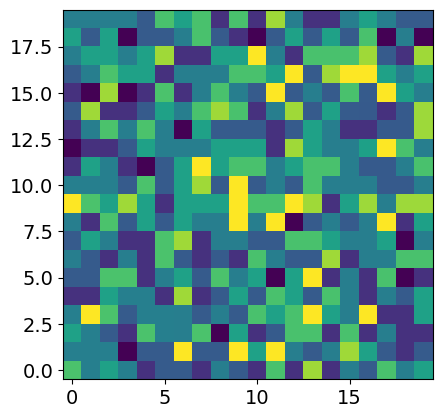

In [251]:
ek.imshow(gi.nuv_im[0].data)